# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Imports here
import numpy as np
import pandas as pd

import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

from collections import OrderedDict

from workspace_utils import active_session

import matplotlib.pyplot as plt

import seaborn as sb

import time

import os 

from PIL import Image

import json

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
def load_data(traindir, validdir, testdir, batch_size=100):
    """
    Load project data/images from a directory.
    Parameters:
     traindir - The directory containing the training data
     validdir - The directory containing the validation data
     testdir - The directory containing the testing data
     batch_size - The size of every batch of data in the datasets
    Returns:
     data_transforms -directory of transformations applied to the data  
    image_datasets -directory of image datasets with applied transformations
     dataloaders -directory of dataloaders containing the batches of train, validation and test data
    """
    # Keep the transforms in a dictionary
    data_transforms = {
        # Training dataset transforms
        'train' : transforms.Compose([transforms.RandomRotation(30),
                                      transforms.Resize(256),
                                      transforms.ColorJitter(),
                                      transforms.CenterCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                     ]),
        # Validation and testing transforms
        'test' : transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], 
                                                          [0.229, 0.224, 0.225])
                                    ]) 
    }

    # DONE: Load the datasets with ImageFolder
    image_datasets = {
        'train' : datasets.ImageFolder(traindir, transform=data_transforms.get('train')),
        'valid' : datasets.ImageFolder(validdir, transform=data_transforms.get('test')),
        'test'  : datasets.ImageFolder(testdir, transform=data_transforms.get('test'))
    }

    # DONE: Using the image datasets and the transforms, define the dataloaders
    dataloaders = {
        'train' : torch.utils.data.DataLoader(image_datasets.get('train'), batch_size=batch_size, shuffle=True),
        'valid' : torch.utils.data.DataLoader(image_datasets.get('valid'), batch_size=batch_size, shuffle=True, drop_last=True),
        'test' : torch.utils.data.DataLoader(image_datasets.get('test'), batch_size=batch_size, shuffle=True, drop_last=True)
    }

    return data_transforms, image_datasets, dataloaders

In [4]:
data_transforms, image_datasets, dataloaders = load_data(train_dir, valid_dir, test_dir, 168)

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
def label_map(traindir, validdir, testdir, categories_file='cat_to_name.json'):
    """
    Load the real images categories with the associated category codes
    Parameters:
     traindir - name of the directory containing the training data
     validdir - name of the directory containing the validation data
     testdir - name of the directory containing the testing data
     categories_file - json file name. File containing the mapping between every category code and the corresponding category name
    Returns:
     n_outputs - the number of available categories 
     cat_to_name -the dictionary containing the mapping between every category code and the corresponding category name  
     train_images -directory of train image with their category code
     valid_images -directory of validation image with their category code
     test_images -directory of test image with their category code
    """
    with open(categories_file, 'r') as f:
        cat_to_name = json.load(f)

    # The number of different category in the 'cat_to_name' file should be the number of output of our n       
    n_outputs = len(cat_to_name.keys())

    # Saves images with categories
    train_images = dict()   
    valid_images = dict()
    test_images = dict()

    # Iterate through each category
    for cat in os.listdir(traindir):    
    
        #Save training images with their categories
        train_imgs = os.listdir(traindir + '/' + cat)
        train_images[cat] = train_imgs 

        #Save validation images with their categories
        valid_imgs = os.listdir(validdir + '/' + cat)
        valid_images[cat] = valid_imgs 

        #Save testing images with their categories
        test_imgs = os.listdir(testdir + '/' + cat)
        test_images[cat] = test_imgs 

    return n_outputs, cat_to_name, train_images, valid_images, test_images

In [6]:
# Map categories code with names and get the number of output for the model
n_outputs, cat_to_name, train_images, valid_images, test_images = label_map(train_dir, valid_dir, test_dir, 'cat_to_name.json')  

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

## Let's start by loading a pretrained model

As recommended we shall use the model VGG16 to build our network.
We freeze all the gradient from the loaded model not to re-train the entire model.

The original classifier input unit, has to be used as input units of our new classifier to end up with 102 outputs as we have **102** different flowers categories to classify.

In [14]:
model.fc.state_dict

<bound method Module.state_dict of Sequential(
  (fc1): Linear(in_features=2048, out_features=1000, bias=True)
  (relu1): ReLU()
  (do2): Dropout(p=0.5)
  (fc3): Linear(in_features=1000, out_features=102, bias=True)
  (output): LogSoftmax()
)>

In [4]:
def create_model (n_outputs, model_architecture='vgg16', hidden_units=1000):

    # Load a pretrained neural network
    if(model_architecture=='vv16'):
        model = models.vgg16(pretrained = True)
    elif model_architecture=='vv13':
        model = models.vgg13(pretrained = True)
    elif model_architecture=='vv19':
        model = models.vgg19(pretrained = True)
    else: 
        model = models.vgg16(pretrained = True)

    # Disable the backpropagation for all the model's layers
    for param in model.parameters():
        param.requires_grad = False

    # create my own classifier. 
    # get the inputs from the former classifier
    n_inputs = model.classifier[0].in_features
    # and we have 102 flowers category to classify
    from collections import OrderedDict
    classifier = nn.Sequential(OrderedDict([
                              ('fc1', nn.Linear(n_inputs, hidden_units)),
                              ('relu1', nn.ReLU()),
                              ('do2', nn.Dropout(0.5)),
                              ('fc3', nn.Linear(hidden_units, n_outputs)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))

    model.classifier = classifier

    return model, classifier

In [8]:
mymodel, classifier = create_model(n_outputs, 'vgg16', 1000)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 101548917.34it/s]


## Configure CUDA

Set up the default configuration to use the **CUDA** when available and the **default CPU** otherwise.


In [9]:
# Use the cuda server when available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Building the blocks

Specifying the learn rate, the error calculation formula (for backpropagation) and the network part to be trained.

In [10]:
# Setting the criterion, the learn rate and traning only the classifier
learnrate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(mymodel.classifier.parameters(), lr=learnrate)

In [11]:
# Define the validation function 
def validation(model, validloader, criterion, device):
    test_loss = 0
    accuracy = 0
    for images, labels in validloader:
        
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [12]:
# Defining the training function
def train_model(model, trainloader, validloader, device, criterion, optimizer, epochs=20, print_every=10):
    steps = 0
    running_loss = 0
    model.to(device)
    for e in range(epochs):
        model.train() # Put the model in training mode
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)                
        
            optimizer.zero_grad()
        
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
            if steps % print_every == 0:
                # Make sure network is in eval mode for inference
                model.eval() # This is to improve the performances and use less machine resources
            
                # Turn off gradients for validation, saves memory and computations
                with torch.no_grad():
                     test_loss, accuracy = validation(model, validloader, criterion, device)
                
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(test_loss/len(validloader)),
                      "Validation Accuracy: {:.3f}".format(accuracy/len(validloader)))

                running_loss = 0
            
            # Make sure training is back on for the next steps and epochs
            model.train()
    return model, optimizer, epochs

In [13]:
# Training the network
with active_session():
    model, optimizer, epochs = train_model(mymodel, dataloaders['train'], dataloaders['train'], device, criterion, optimizer, epochs=5, print_every=50)

Epoch: 1/5..  Training Loss: 4.139..  Validation Loss: 2.113..  Validation Accuracy: 0.547
Epoch: 1/5..  Training Loss: 2.215..  Validation Loss: 1.159..  Validation Accuracy: 0.730
Epoch: 1/5..  Training Loss: 1.577..  Validation Loss: 0.697..  Validation Accuracy: 0.839
Epoch: 2/5..  Training Loss: 1.076..  Validation Loss: 0.507..  Validation Accuracy: 0.875
Epoch: 2/5..  Training Loss: 0.754..  Validation Loss: 0.356..  Validation Accuracy: 0.912
Epoch: 2/5..  Training Loss: 0.691..  Validation Loss: 0.302..  Validation Accuracy: 0.924
Epoch: 2/5..  Training Loss: 0.611..  Validation Loss: 0.272..  Validation Accuracy: 0.933
Epoch: 3/5..  Training Loss: 0.558..  Validation Loss: 0.215..  Validation Accuracy: 0.950
Epoch: 3/5..  Training Loss: 0.376..  Validation Loss: 0.176..  Validation Accuracy: 0.957
Epoch: 3/5..  Training Loss: 0.377..  Validation Loss: 0.153..  Validation Accuracy: 0.960
Epoch: 3/5..  Training Loss: 0.409..  Validation Loss: 0.142..  Validation Accuracy: 0.965

## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [14]:
# DONE: Do validation on the test set
def test_model(model, testloader, device='cuda'):

    # Load the model to CUDA
    model.to(device)
    # Put the model to evaluation mode
    model.eval()
    images, labels = next(iter(dataloaders.get('test')))
    images, labels = images.to(device), labels.to(device) 

    # Initialize the model accuracy to 0
    accuracy = 0
    
    # Turn off gradients to speed up this part
    with torch.no_grad():
        logits = mymodel.forward(images)
        
    ps = torch.exp(logits)
    equality = (labels.data == ps.max(dim=1)[1])
    accuracy += equality.type(torch.FloatTensor).mean()
    print("Model accuracy on test dataset : {}% ".format(accuracy * 100))

    return model, accuracy

In [15]:
mymodel, accuracy = test_model(mymodel, dataloaders['test'], device)

Model accuracy on test dataset : 89.8809585571289% 


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [16]:
# DONE: create the function that saves the checkpoint
def save_model(model, model_name, epochs, optimizer, path='checkpoint.pth', train_categories=None):
    # bring the model back to the cpu in case it's on cuda
    model.to('cpu')
    
    checkpoint = {'epochs': epochs,
                  'model_arch': model_name,
              'model_state_dict': model.state_dict(),
              'model_classifier': model.classifier,
              'classifier_state_dict': model.classifier.state_dict,
              'optimizer': optimizer,
              'optimizer_state_dict': optimizer.state_dict(),              
              'categories': train_categories,
             }
    torch.save(checkpoint, path)
    

In [17]:
# Save the model
save_model(mymodel, 'vgg16', 5, optimizer, 'vgg16_model_gpe.pth', cat_to_name)

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [18]:
# DONE: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint_path):
    model = None
    optimizer = None
    class_to_idx = None
    epochs = None
    
    # Load the check point
    checkpoint = torch.load(checkpoint_path)
    model_architecture = checkpoint.get('model_arch')
    # Load a pretrained neural network
    if(model_architecture=='vv16'):
        model = models.vgg16(pretrained = True)
    elif model_architecture=='vv13':
        model = models.vgg13(pretrained = True)
    elif model_architecture=='vv19':
        model = models.vgg19(pretrained = True)
    else: 
        model = models.vgg16(pretrained = True)
        
    # Create a new model of type vgg16
    model = models.vgg16(pretrained=True)
    # Disable the backpropagation for all the layers
    for param in model.parameters():
        param.requires_grad = False
    
    model.state_dict = checkpoint.get('model_state_dict')
    model.classifier = checkpoint.get('model_classifier')
    model.classifier.state_dict = checkpoint.get('classifier_state_dict')
    
    # Create a new Adam optimizer 
    optimizer = checkpoint.get('optimizer')
    optimizer.load_state_dict(checkpoint.get('optimizer_state_dict'))
    
    # Retrieve the flowers categories in case it's saved
    train_categories = checkpoint.get('categories')
    
    # Retrieve the number of epochs
    epochs = checkpoint.get('epochs')
    
    return model, optimizer, epochs, train_categories
    

In [19]:
new_model, optimizer, epochs, train_categories = load_model('vgg16_model_gpe.pth')

In [20]:
new_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Open the image
    img = Image.open(image)
    
    # Retrive the original size
    width, height = img.size
    
    # Compute the new size considering the shortest side to be 256 pixels and keeping the aspect ratio
    if(width > height):
        new_width = int(256*width/height)
        new_height = 256        
    else:
        new_width = int(256*width/height)
        new_height = 256
    
    # Resize the image
    img = img.resize((new_width, new_height))
    
    # Center crop the image
    left = (new_width - 224) / 2
    top = (new_height - 224) / 2
    right = (new_width + 224) / 2
    bottom = (new_height + 224) / 2
    img = img.crop((left, top, right, bottom))
    
    # We divide by 256 as 0-255 is 256 values
    np_img = np.array(img) / 256

    means = np.array([0.485, 0.456, 0.406])
    stds = np.array([0.229, 0.224, 0.225])

    # Normalizing the image
    np_img -= means

    np_img /= stds
    
    return torch.Tensor(np_img.transpose())


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [22]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

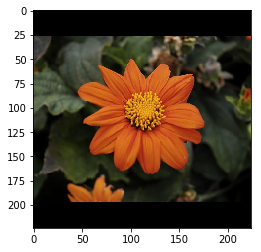

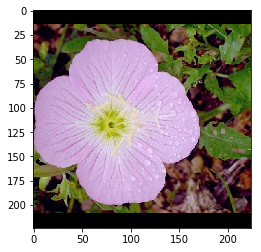

In [21]:
imshow(process_image(test_dir + '/59/' + 'image_05039.jpg'))
imshow(process_image(train_dir + '/1/' + 'image_06741.jpg'))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [23]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''        
    image = process_image(image_path)
    
    # Check if the model is on cuda and bring it back to cpu
    if(next(model.parameters()).is_cuda):
        model.to("cpu")     

    # Turn off gradients to speed up this part
    with torch.no_grad():
        model.eval()
        logits = model.forward(image.unsqueeze_(0))
        ps = torch.exp(logits)
        
    prob, classes = ps.topk(topk, dim=1)
    
    return prob.reshape((topk)).numpy(), classes.reshape((topk)).numpy()
    

## Create some utility functions
It is important to create some utility functions to like one to randomly choose images to test the prediction accuracy and see if it makes sense.
Here we are creating two utility function:
`get_name()` to get the real class of an image from the path 
`get_random_img()` to pick a random image and test the accuracy of the model  

In [24]:
def get_name(image_path, cat_catalogue):
    ''' From an image path and the dictionary containing the corresponding image class name and class code, return the image class name.
    ''' 
    img_class = image_path.split('/')[-2]
    return cat_catalogue[img_class]

In [25]:
def get_random_img(adir=test_dir):
    ''' Pick a random image from a directory'''
    sep = os.path.sep
    class_id = np.random.choice(os.listdir(adir))
    img_name = np.random.choice(os.listdir(adir + sep + class_id))
    return adir + sep + class_id + sep + img_name

In [26]:
probs, classes = predict(test_dir + '/59/' + 'image_05039.jpg', mymodel,102)
classes

array([ 47,  30,  57,  54,  65,  61,   2,  38,  51,  46,  43,  71,  64,
        78,  68,  63,  73,  11,  84,  28,  83,  87,  70,   6,  34,  62,
        66,  98,  49,  44,  45,  97,  59,  89,   9,  48,  42,  55,  90,
        21,  50,  56,  60,  77,  17,  74,   4,  96,  52,   0,  88,  10,
        99,   3,  85,  80,  53,  82,  41,   1,  12,  26,  13,  94,  39,
        37,  24,  92,  19,  81,  33,  95,  20,  72,  40, 101,  15,   7,
        76,  79,  35,  16,   8,  27,  18,  58,  93,  22,   5,  14,  67,
        23,  31,  36, 100,  29,  25,  32,  75,  86,  69,  91])

In [27]:
probs

array([  5.24462044e-01,   2.25230411e-01,   1.61088839e-01,
         7.03845695e-02,   1.78781990e-02,   6.44573069e-04,
         1.46063161e-04,   7.90359190e-05,   7.73258289e-05,
         2.80130757e-06,   1.77596417e-06,   1.61935634e-06,
         7.81812219e-07,   5.78683171e-07,   4.84574684e-07,
         2.85073583e-07,   2.23898340e-07,   1.20579116e-07,
         7.12942949e-08,   6.97280953e-08,   2.32019595e-08,
         2.31823201e-08,   1.89526776e-08,   8.58162341e-09,
         7.50357909e-09,   5.69710945e-09,   4.70826489e-09,
         2.15235918e-09,   1.69406877e-09,   1.14406473e-09,
         1.10868159e-09,   1.34205688e-10,   1.30958619e-10,
         1.10597337e-10,   8.84625914e-11,   8.36732697e-11,
         7.24612592e-11,   5.93545144e-11,   3.16015651e-11,
         2.93341774e-11,   2.92400514e-11,   1.50896049e-11,
         1.13272725e-11,   8.99556037e-12,   6.83922060e-12,
         5.53105348e-12,   5.33723109e-12,   4.81194685e-12,
         3.44199474e-12,

In [37]:
img_class_name = get_name(img_name, cat_to_name)
img_class_name

'morning glory'

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

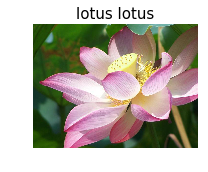

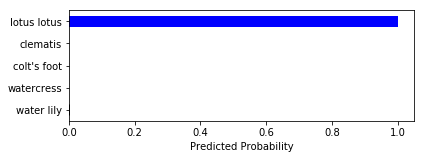

In [32]:
# DONE: Display an image along with the top 5 classes
image_path = get_random_img()

# Classify the image 
probs, classes = predict(image_path, mymodel, 5)

# get classes names
class_names = []

image_real_class = get_name(image_path, cat_to_name)

# Retrieving the class names
for i in range(len(classes)):
    class_names.append(cat_to_name.get(str(classes[i])))

result = pd.DataFrame({'p': probs}, index=class_names)

# Show the image
img = Image.open(image_path)
plt.figure(figsize=(15, 5))
ax = plt.subplot(2, 1, 1)
# Set title to be the actual class
ax.set_title(image_real_class, size=15)
plt.axis('off')
plt.imshow(img)
plt.show()

ax = plt.subplot(2, 1, 2)
# Plot a bar plot of predictions
result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
plt.xlabel('Predicted Probability')
plt.tight_layout()

In [111]:
classes

array([ 0, 90, 99, 53, 49])